In [5]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
directory = 'ml-latest-small'


movies = pd.read_csv(os.path.join(directory, 'movies.csv'))
ratings = pd.read_csv(os.path.join(directory, 'ratings.csv'))
print(movies.shape)

movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [7]:
# split values column genres into multiple columns. Split on '|'
movies = pd.concat([movies, movies['genres'].str.get_dummies(sep='|')], axis=1) 

Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
dtype: int64


Text(0.5, 0, 'Number of items')

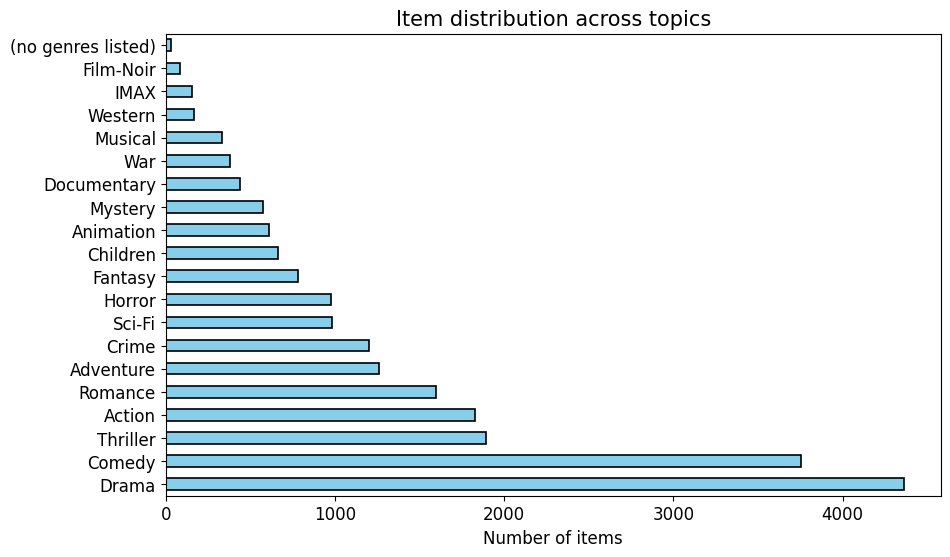

In [8]:
# count for each genre the number of occurrences
genre_count = movies.iloc[:, 3:].sum().sort_values(ascending=False)
print(genre_count)

# plot the number of occurrences for each genre
genre_count.plot(kind='barh', figsize=(10, 6), fontsize=12, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Item distribution across topics', fontsize=15)
plt.xlabel("Number of items", fontsize=12)

Text(0.5, 0, 'Number of occurences')

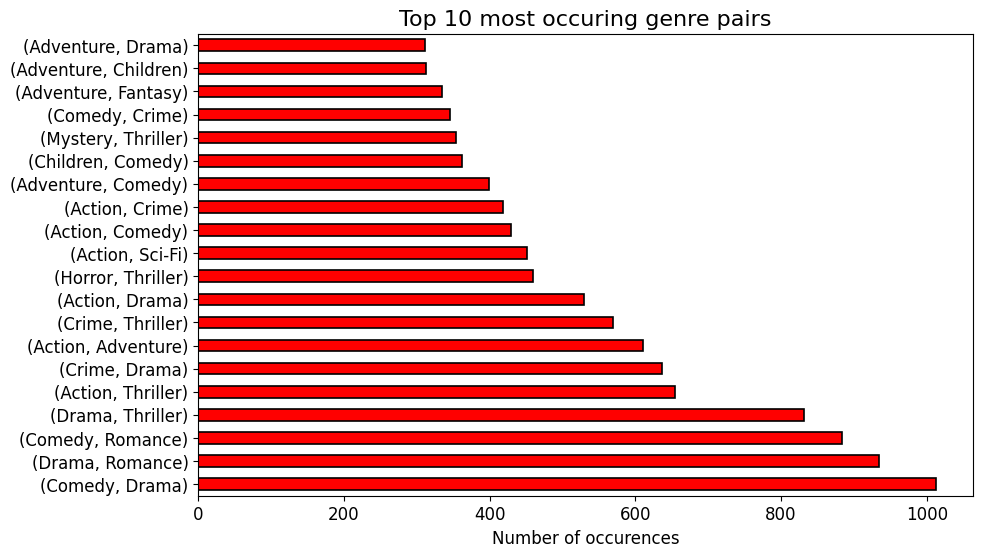

In [9]:
# plot the most occuring genre pairs
genre_pairs = movies.iloc[:, 3:].T.dot(movies.iloc[:, 3:])
# set pairs where the same genre is counted as 0
np.fill_diagonal(genre_pairs.values, 0)

# find the most occuring genre pairs
genre_pairs = genre_pairs.unstack().sort_values(ascending=False)

# remove the duplicates
genre_pairs = genre_pairs[genre_pairs.index.get_level_values(0) < genre_pairs.index.get_level_values(1)]

# remove pairs with 0 occurrences
genre_pairs = genre_pairs[genre_pairs > 0]


# plot the top 10 most occuring genre pairs as horizontal bar plot
genre_pairs.head(20).plot(kind='barh', figsize=(10, 6), fontsize=12, color='red', edgecolor='black', linewidth=1.2)
# plot title
plt.title('Top 10 most occuring genre pairs', fontsize=16)
plt.xlabel("Number of occurences", fontsize=12)

<Figure size 1000x600 with 0 Axes>

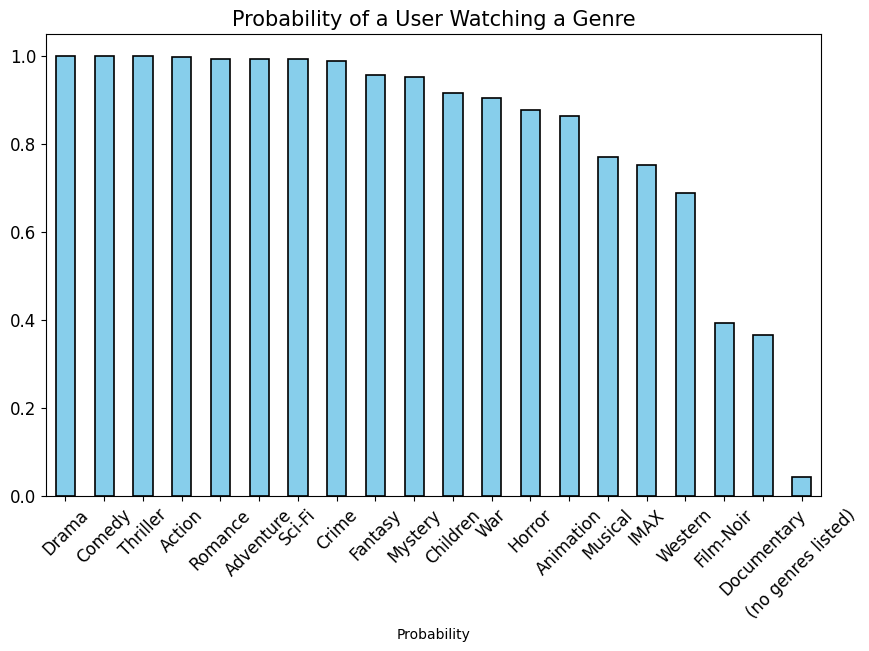

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize a dictionary to store genre counts per user
user_genre_count = defaultdict(set)

# Load the data in chunks
chunksize = 1e6  # Adjust the chunksize based on your memory capacity
for chunk in pd.read_csv(os.path.join(directory, 'ratings.csv'), chunksize=chunksize):
    # Merge each chunk with the movies data
    chunk = pd.merge(chunk, pd.read_csv(os.path.join(directory, 'movies.csv')), on='movieId')
    
    # Split genres into individual columns
    chunk = chunk.assign(genres=chunk['genres'].str.split('|'))
    
    # Explode the genres into separate rows
    chunk = chunk.explode('genres')
    
    # Count unique genres per user
    for row in chunk.itertuples():
        user_genre_count[row.userId].add(row.genres)

# Convert the dictionary to a DataFrame
genre_user_count = defaultdict(int)
for genres in user_genre_count.values():
    for genre in genres:
        genre_user_count[genre] += 1

# Create a DataFrame for plotting
genre_count_df = pd.DataFrame(list(genre_user_count.items()), columns=['Genre', 'UserCount']).sort_values(by='UserCount', ascending=False)
genre_count_df["UserCount"] = genre_count_df["UserCount"]/len(user_genre_count)
# Plot the result. Do not plot legenda as it is not useful in this case
plt.figure(figsize=(10, 6))
genre_count_df.plot(kind='bar', x='Genre', y='UserCount', figsize=(10, 6), fontsize=12, color='skyblue', edgecolor='black', linewidth=1.2, legend=False)
plt.xlabel('Probability')
plt.xticks(rotation=45)
plt.title('Probability of a User Watching a Genre', fontsize=15)
plt.show()


# Defining a User Embedding $e_u$

Define user embedding $e_i$ based on prior distribution $p_{\tau}$.

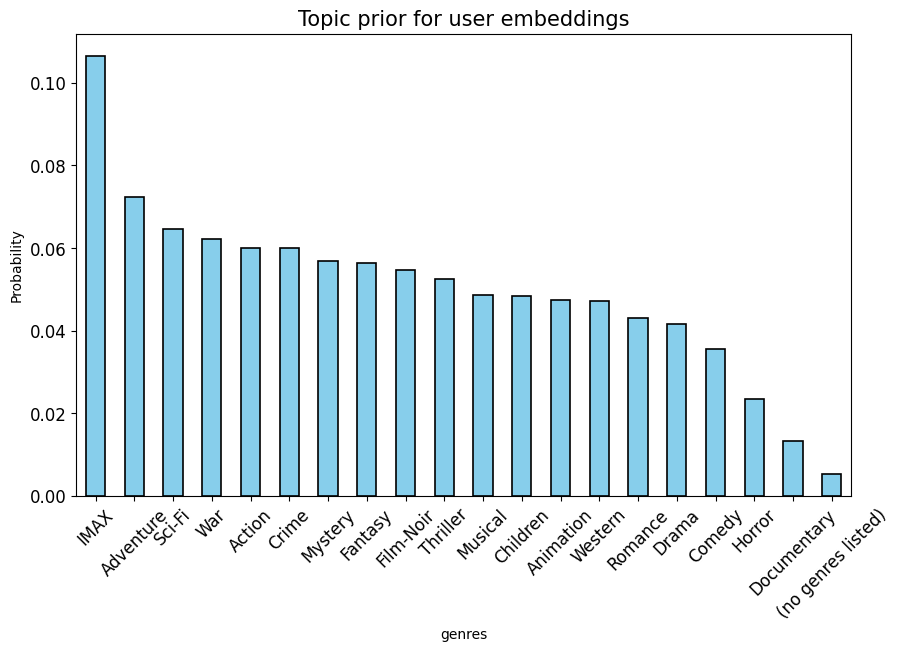

In [11]:
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Split genres into individual columns
movie_ratings = movie_ratings.assign(genres=movie_ratings['genres'].str.split('|'))

# Explode the genres into separate rows
movie_ratings = movie_ratings.explode('genres')

movie_ratings

# per movie, count the number of likes, i.e. ratings >= 4
movie_ratings['like'] = movie_ratings['rating'] >= 4

# group by movie and genre and count the number of likes
genre_likes = movie_ratings.groupby(['movieId', 'genres'])['like'].sum()

# calculate the average number of likes per genre

genre_likes = genre_likes.groupby('genres').mean().sort_values(ascending=False)

# Divide the average number of likes by the total number of likes
genre_likes = genre_likes/genre_likes.sum()

# Plot the result
genre_likes.plot(kind='bar', figsize=(10, 6), fontsize=12, color='skyblue', edgecolor='black', linewidth=1.2)
plt.ylabel('Probability')
plt.title('Topic prior for user embeddings', fontsize=15)
plt.xticks(rotation=45)
plt.show()


On average, IMAX movies are liked more compared to other movies of other genres. 

In [12]:
priors = np.array(list(genre_likes))

# save the priors to a npz file
np.savez_compressed(os.path.join("embeddings",f'{directory}_priors.npz'), priors=priors)

In [13]:
def normalize_to_unit_euclidean_norm(e_i):
    """
    Normalizes the input vector to have a unit Euclidean norm.
    
    Parameters:
    e_i (array-like): The input vector to be normalized.
    
    Returns:
    np.ndarray: The normalized vector with a unit Euclidean norm.
    """
    e_i = np.array(e_i)
    norm = np.linalg.norm(e_i)
    if norm == 0:
        return e_i 
    normalized_e_i = e_i / norm
    return normalized_e_i

class User:
    def __init__(self, priors):
        def generate_user_embedding(priors):
            # Normalize priors to sum to 1
            priors = np.array(priors)
            priors /= priors.sum()

            # Sample 6 to 10 times
            samples = np.random.choice(len(priors), size=np.random.choice([6,7,8,9,10]), p=priors)
            samples

            embedding = np.zeros(len(priors))
            # set values to one for the sampled indices
            embedding[samples] = 1

            # Normalize the embedding
            embedding = normalize_to_unit_euclidean_norm(embedding)
            
            return embedding

        self.embedding = generate_user_embedding(priors)
        self.main_topic = np.argmax(self.embedding)

    def __str__(self):
        return f"{self.embedding}"

# Create a user
user = User(priors)
print(user)

[0.35355339 0.35355339 0.35355339 0.35355339 0.         0.
 0.         0.         0.35355339 0.         0.         0.
 0.         0.         0.         0.35355339 0.35355339 0.35355339
 0.         0.        ]


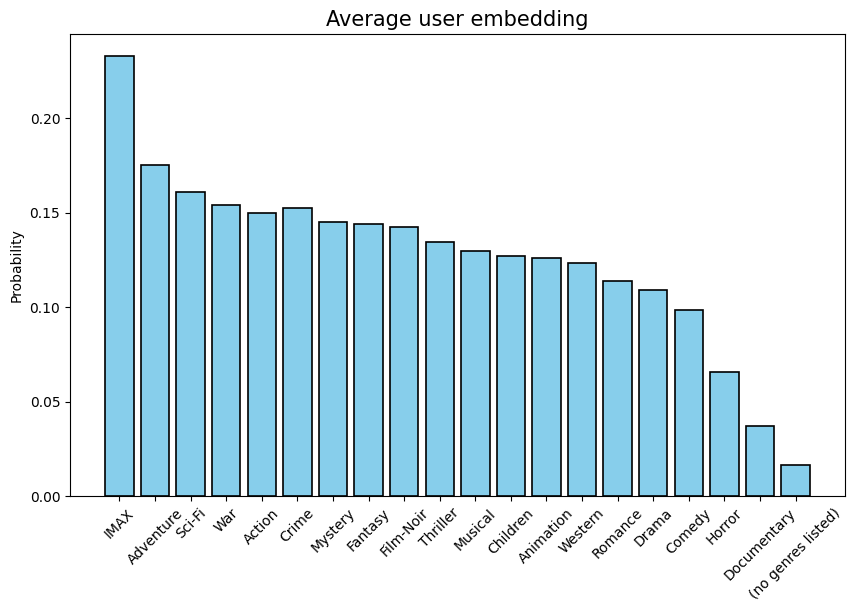

In [14]:
n = 10000

avg = np.zeros(len(priors))
for i in range(n):
    user = User(priors)
    avg += user.embedding

avg /= n

# Plot the result
plt.figure(figsize=(10, 6))
plt.bar(range(len(priors)), avg, color='skyblue', edgecolor='black', linewidth=1.2)
plt.xticks(range(len(priors)), genre_likes.index, rotation=45)
plt.ylabel('Probability')
plt.title('Average user embedding', fontsize=15)
plt.show()

Normalize the components to have an embedding with unitary Euclidean norm: $\boldsymbol{e}_i := \frac{\boldsymbol{e}_i}{||\boldsymbol{e}_i||_2}$

# Movie Quality $L_d$ (Ie et al. 2019)

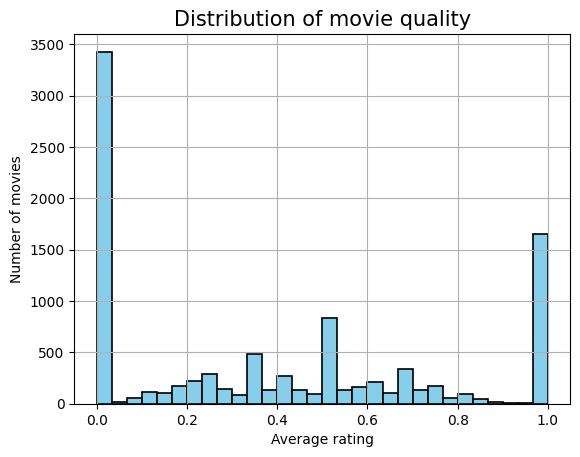

In [15]:
ratings["Good"] = ratings["rating"] >= 4

# Count the average rating per movie based on the "Good" column
average_rating = ratings.groupby("movieId")["Good"].mean()

# for each movie assign its average rating
movies = pd.merge(movies, average_rating, on='movieId')
movies.rename(columns={'Good': 'quality'}, inplace=True)

average_rating.hist(bins=30, color='skyblue', edgecolor='black', linewidth=1.2)

plt.xlabel('Average rating')
plt.ylabel('Number of movies')
plt.title('Distribution of movie quality', fontsize=15)
plt.show()

# Normalizing item embeddings $\boldsymbol{e}_i$

In [16]:
list(genre_likes.index)

['IMAX',
 'Adventure',
 'Sci-Fi',
 'War',
 'Action',
 'Crime',
 'Mystery',
 'Fantasy',
 'Film-Noir',
 'Thriller',
 'Musical',
 'Children',
 'Animation',
 'Western',
 'Romance',
 'Drama',
 'Comedy',
 'Horror',
 'Documentary',
 '(no genres listed)']

In [18]:
m_list = []
for index, row in movies.iterrows():
    embedding = [row[j] for j in list(genre_likes.index)]
    embedding = normalize_to_unit_euclidean_norm(embedding)
    quality = row["quality"]
    
    # Combine embedding and quality into a single list
    combined = list(embedding) + [quality]
    
    m_list.append(combined)

item_embeddings = np.array(m_list)

# save item_embeddings to a npz file 
np.savez_compressed(os.path.join("embeddings", f'{directory}.npz'), item_embeddings=item_embeddings)


# save item_embeddings to a npy file
np.save(os.path.join("embeddings", f'{directory}.npy'), item_embeddings)

In [20]:
item_embeddings.shape

(9724, 21)